<a href="https://colab.research.google.com/github/FaizanHameed1/Bitcoin-Price-Prediction-using-LSTM/blob/main/Bitcoin_Price_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bitcoin Price Using LSTM

## Faizan Hameed

### 1-Downloading Dataset in Google Drive

In [171]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [172]:
#Run only 1st time
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [173]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [174]:
#Check the present working directory
import os
os.getcwd() 


'/content/gdrive/My Drive/Kaggle'

In [175]:
#Run this cell only 1st time to download the dataset in spacified directory 
# Copy the API command from Kaggle Dataset and paste(using !) to download the data
#!kaggle datasets download -d mczielinski/bitcoin-historical-data

In [176]:
#check the content in our directory
!ls

BC_Data.csv  coin_Bitcoin.csv  kaggle.json


In [177]:
#Run only once to unzip the Dataset
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

### 2-Importing Libraries 

In [180]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, LeakyReLU,Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.models import model_from_json
%matplotlib inline

In [181]:
d_frame=pd.read_csv('BC_Data.csv')
print('1st 5 rows')
d_frame.head(5)

1st 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
#d_frame.info()# Here datatype of Timestamp is "int64".

In [183]:
#d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],infer_datetime_format=True) #We converted in "Timestamp" format. Now datatype of "Timestamp" is object but we used"infer_datetime_format=True" that converts "Timestamp" format from "object" to "datetime64" format)
#d_frame.head()

In [184]:
#d_frame.info()

In [185]:
d_frame.shape # No of rows and columns in this dataframe 

(4857377, 8)

In [186]:
# We want to replace missing values i.e "?" to Python's default missing value marker "NaN"
d_frame.replace("?", np.nan, inplace = True)
d_frame.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1325318340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1325318400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1325318460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
#After converting to default now detecting missing data(we can use .isnull()
#or .notnull() method)
#True" stands for missing value, while "False" stands for not missing value.
missing_values = d_frame.isnull()
missing_values.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,False,False,False,False,False,False,False,False
1,False,True,True,True,True,True,True,True
2,False,True,True,True,True,True,True,True
3,False,True,True,True,True,True,True,True
4,False,True,True,True,True,True,True,True
5,False,True,True,True,True,True,True,True
6,False,True,True,True,True,True,True,True
7,False,True,True,True,True,True,True,True
8,False,True,True,True,True,True,True,True
9,False,True,True,True,True,True,True,True


In [188]:
# Checking the missing values in each column
for column in missing_values.columns.values.tolist():
    print(column)
    print (missing_values[column].value_counts())
    print("") 

Timestamp
False    4857377
Name: Timestamp, dtype: int64

Open
False    3613769
True     1243608
Name: Open, dtype: int64

High
False    3613769
True     1243608
Name: High, dtype: int64

Low
False    3613769
True     1243608
Name: Low, dtype: int64

Close
False    3613769
True     1243608
Name: Close, dtype: int64

Volume_(BTC)
False    3613769
True     1243608
Name: Volume_(BTC), dtype: int64

Volume_(Currency)
False    3613769
True     1243608
Name: Volume_(Currency), dtype: int64

Weighted_Price
False    3613769
True     1243608
Name: Weighted_Price, dtype: int64



We can see from data that there are whole rows of missing values which we can't handle. Only we can do is to remove them. To remove the whole rows first of all we will remove those rows that have not "Weighted_Price" values because , we are going to predict the "Weighted_Price" so without it all other row data is useless.

In [189]:
# simply drop whole rows with NaN in "Weighted_Price" column
d_frame.dropna(subset=["Weighted_Price"], axis=0, inplace=True)

# reset index, because we droped many rows
d_frame.reset_index(drop=True, inplace=True)
d_frame.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
5,1325431680,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000
6,1325457900,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000
7,1325534640,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
8,1325591100,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000
9,1325600520,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000


In [190]:
#checking that if there is any missing value. 
d_frame.isnull().values.any()

False

"False" mean that there is no missing value in our dataframe.

Now we are going to convert time stemp to date.

In [191]:
d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],unit='s').dt.date #We converted in time stamp format
#d_frame = d_frame.set_index(['Timestamp']) #If we want to set "Timestamp" as index.
d_frame.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,2011-12-31,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,2011-12-31,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,2012-01-01,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
5,2012-01-01,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000
6,2012-01-01,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000
7,2012-01-02,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
8,2012-01-03,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000
9,2012-01-03,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000


In [192]:
#d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],infer_datetime_format=True) #We converted in "Timestamp" format. Now datatype of "Timestamp" is object but we used"infer_datetime_format=True" that converts "Timestamp" format from "object" to "datetime64" format)
#d_frame.head()

In [193]:
print('last 5 rows')
d_frame.tail(5)

last 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3613764,2021-03-30,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
3613765,2021-03-30,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
3613766,2021-03-30,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
3613767,2021-03-30,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
3613768,2021-03-31,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


We can see that our data is upto date. Starting from Dec 2011 to March 2021

In [194]:
d_frame.shape # No of rows and columns in this dataframe 

(3613769, 8)

There are multiple readings at every day in dataframe so  grouping data w.r.t "Timestamp" and taking the mean so that we can convert in single reding per day by taking the mean across the column.

In [195]:
grouping=d_frame.groupby('Timestamp')
df=grouping['Open', 'High', 'Low', 'Close', 'Volume_(BTC)','Volume_(Currency)', 'Weighted_Price'].mean()
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...
2021-03-27,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
2021-03-28,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
2021-03-29,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3376 entries, 2011-12-31 to 2021-03-31
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               3376 non-null   float64
 1   High               3376 non-null   float64
 2   Low                3376 non-null   float64
 3   Close              3376 non-null   float64
 4   Volume_(BTC)       3376 non-null   float64
 5   Volume_(Currency)  3376 non-null   float64
 6   Weighted_Price     3376 non-null   float64
dtypes: float64(7)
memory usage: 211.0+ KB


In [197]:
print(df.dtypes)

Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object


In [198]:
df.corr()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,1.000000,1.000000,1.000000,1.000000,-0.216872,0.766819,1.000000
High,1.000000,1.000000,1.000000,1.000000,-0.216749,0.767050,1.000000
Low,1.000000,1.000000,1.000000,1.000000,-0.217006,0.766560,1.000000
Close,1.000000,1.000000,1.000000,1.000000,-0.216871,0.766813,1.000000
Volume_(BTC),-0.216872,-0.216749,-0.217006,-0.216871,1.000000,0.016652,-0.216884
Volume_(Currency),0.766819,0.767050,0.766560,0.766813,0.016652,1.000000,0.766804
Weighted_Price,1.000000,1.000000,1.000000,1.000000,-0.216884,0.766804,1.000000


In [199]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price'],
      dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efc1c170f10>,
      dtype=object)

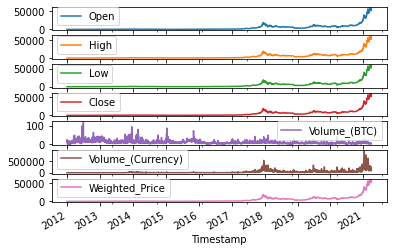

In [200]:
df['Timestamp'] = df.index #reseting "Timestamp" from index to column, only to plot the data w.r.t Timestamp 
df.set_index('Timestamp')[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price']].plot(subplots=True) #Before this command it is important to convert into timestamp format because it plot the data w.r.t timestamp. This command is some of the commands that are used to plot time series data.We set the Timestamp as index by using 'Volume_(BTC)' command.

In [201]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'Timestamp'],
      dtype='object')

It look like that the data is non-stationary. The stationary data have constant mean, variance and covariance.

In [202]:
df.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000
mean,4605.644798,4608.916329,4602.220278,4605.640430,10.355675,31790.810259,4605.576442
std,8207.258774,8213.768034,8200.562238,8207.368264,8.897358,62753.976425,8207.031620
min,4.331667,4.331667,4.331667,4.331667,0.250000,1.227500,4.331667
25%,244.954735,245.046306,244.869102,244.959590,4.671673,1916.186042,244.952580
50%,697.954849,698.221190,697.654114,697.921509,7.622244,6832.004108,697.948484
75%,7242.739376,7248.233526,7238.040275,7242.417035,13.114867,36074.508308,7242.892623
max,60458.339735,60488.868334,60426.441554,60458.888892,119.522868,950995.602917,60455.844831


We can see that our data have many outliers in almost all columns.

In [203]:
df.query('Weighted_Price>8.627637e+03')# We have used 75% value to check outliers.

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp
Timestamp,,,,,,,,
2017-11-26,8972.660382,8979.546725,8963.421064,8972.624117,8.359677,75469.969018,8971.770344,2017-11-26
2017-11-27,9556.623951,9562.756576,9547.797125,9556.814924,9.216981,87818.137268,9555.697055,2017-11-27
2017-11-28,9833.341953,9839.344726,9824.100466,9833.134767,7.793558,76787.182660,9832.286236,2017-11-28
2017-11-29,10418.308685,10432.556659,10400.521645,10418.194440,24.017486,249245.375145,10416.668393,2017-11-29
2017-11-30,9889.501764,9906.492917,9868.535028,9888.908549,17.662124,171592.951919,9887.543387,2017-11-30
...,...,...,...,...,...,...,...,...
2021-03-27,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260,2021-03-27
2021-03-28,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824,2021-03-28
2021-03-29,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819,2021-03-29


In [204]:
df.query('Weighted_Price<4.438306e+02')# We have used 25% value to check outliers. 

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp
Timestamp,,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,2011-12-31
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,2012-01-01
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,2012-01-02
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,2012-01-03
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,2012-01-04
...,...,...,...,...,...,...,...,...
2016-04-20,438.542243,438.654158,438.414087,438.524787,6.739935,2956.234073,438.524971,2016-04-20
2016-05-20,441.600490,441.685991,441.510345,441.612895,3.839897,1693.704250,441.591221,2016-05-20
2016-05-21,442.420288,442.484928,442.357590,442.432662,3.446825,1519.025563,442.422490,2016-05-21


In [205]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'Timestamp'],
      dtype='object')

In [206]:
df_in=df[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price']]  # Time stamp is not included in input dataframe

We can also check other colums for number of outliers. Standard scaler will not account the outliers so we use "MinMaxScaler"

In [207]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(df_in)
scaled_data #Data is b/w 0 and 1

array([[2.20553339e-06, 2.49375033e-06, 2.20669774e-06, ...,
        1.97693490e-01, 1.10518618e-04, 2.31485037e-06],
       [7.85721270e-06, 7.85324690e-06, 7.86136070e-06, ...,
        5.82753379e-02, 3.57859319e-05, 7.85753698e-06],
       [1.10552361e-05, 1.10496562e-05, 1.10610724e-05, ...,
        1.57604997e-01, 9.88570516e-05, 1.10556924e-05],
       ...,
       [9.41385968e-01, 9.41428753e-01, 9.41392338e-01, ...,
        2.92009995e-02, 2.24768236e-01, 9.41410052e-01],
       [9.65088599e-01, 9.65000757e-01, 9.65203386e-01, ...,
        1.77240564e-02, 1.45353136e-01, 9.65113651e-01],
       [9.72035109e-01, 9.71716931e-01, 9.72353306e-01, ...,
        2.06487115e-02, 1.67631405e-01, 9.72018972e-01]])

In [208]:
features=scaled_data           #(Multivariate data going to be the input of LSTM model)All columns including 'Weighted_Price' because we want to predict future values using past values of 'Weighted_Price' along with other variables (Timestamp is not icluded). All
target=scaled_data[:,-1]        #only 'Weighted_Price' column (Timestamp is not included)

In [209]:
features

array([[2.20553339e-06, 2.49375033e-06, 2.20669774e-06, ...,
        1.97693490e-01, 1.10518618e-04, 2.31485037e-06],
       [7.85721270e-06, 7.85324690e-06, 7.86136070e-06, ...,
        5.82753379e-02, 3.57859319e-05, 7.85753698e-06],
       [1.10552361e-05, 1.10496562e-05, 1.10610724e-05, ...,
        1.57604997e-01, 9.88570516e-05, 1.10556924e-05],
       ...,
       [9.41385968e-01, 9.41428753e-01, 9.41392338e-01, ...,
        2.92009995e-02, 2.24768236e-01, 9.41410052e-01],
       [9.65088599e-01, 9.65000757e-01, 9.65203386e-01, ...,
        1.77240564e-02, 1.45353136e-01, 9.65113651e-01],
       [9.72035109e-01, 9.71716931e-01, 9.72353306e-01, ...,
        2.06487115e-02, 1.67631405e-01, 9.72018972e-01]])

In [210]:
target

array([2.31485037e-06, 7.85753698e-06, 1.10556924e-05, ...,
       9.41410052e-01, 9.65113651e-01, 9.72018972e-01])

In [211]:
features.shape

(3376, 7)

In [212]:
target.shape

(3376,)

In [213]:
# Splitting the Training and Test data
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.0092,random_state=42,shuffle=False)

In [214]:
x_train.shape

(3344, 7)

In [215]:
x_test.shape

(32, 7)

In [216]:
y_train.shape

(3344,)

In [217]:
y_test.shape

(32,)

In [ ]:
win_length=720
batch_size=32
num_features=7
# Time series generator is used to prepare data.Feature column(x_train or x_test) & Target column(y_train,y_test) are passed.
#window_length is number of time periods of data. It will take these numbers of time periods of data and predict the next.
train_generator=TimeseriesGenerator(x_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)
train_generator=TimeseriesGenerator(x_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)

train_generator #it will contain 32 observations equal to "batch_size" each have further observations equal to "win_length" & further each observation contain equal to "num_features" features.The are also 32 target columns equel to batch size 

In [218]:
model = Sequential()
# In following line of code,128 is LSTM output.We set"return_sequences=True" because we require hidden state for each of our input data otherwise it will return
#only one hidden state for all the input data.it is time series data so we need to have hidde state for each and every observation.
model.add(LSTM(128,input_shape=(win_length,num_features),return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))# return only single hidden state. If we want to further use other layers before final layer we can set it equel to true.
model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 720, 128)          69632     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 720, 128)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 720, 128)          131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 720, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 720, 128)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [219]:
# Early stopping is if our validation loss is not improving then it will stop the training earlier.it will observe 2 iterations for validation loss improvement.
earl_stop=EarlyStopping(monitor="val_loss",patience=2,mode='min')

In [220]:
#Compiling the model
model.compile(loss = MeanSquaredError(), optimizer=Adam(),metrics =[MeanAbsoluteError()])

In [ ]:
epochs=30
#Training our model
history=model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,shuffle=False,callback=earl_stop)

In [ ]:
#saving the model

model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("final_model.h5")

In [ ]:
model.evaluate(test_generator,verbose=0)# checking the performance of our model

In [ ]:
predict=model.predict_generator(test_generator)

In [ ]:
predict